In [1]:
import json,os,jieba
import numpy as np
import pandas as pd
from collections import Counter
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

tok2id_p="./idftab/tok2id.json"
idftab_p="./idftab/idftab.json"

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)
corpus_p="./corpus_q_jieba.json"
with open(corpus_p,"r",encoding="utf-8") as fr:
    qcorpus=json.load(fr)

with open(doc2q_p,"r",encoding="utf-8") as fr:
    doc2q=json.load(fr) # key为字符串;

with open(attmap_p,"rb") as fr:
    attmap=cPickle.load(fr)

with open(query_offset_p,"rb") as fr:
    query_offset=cPickle.load(fr) # get only the cls token att; get only from CLS to SEP-1;

with open(tok2id_p,"r",encoding="utf-8") as fr:
    tok2idtab=json.load(fr)

with open(idftab_p,"r",encoding="utf-8") as fr:
    idftab=json.load(fr)

# 如果去除停用词的话
stopword_p="stopword.txt"
with open(stopword_p, 'r',encoding="utf-8") as g:
    words = g.readlines() #stop words
stopwords = [i.strip() for i in words]
qdict={}
with open(query_p,'r',encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        entry=eval(line)
        rid=entry["ridx"]
        qdict[rid]=entry["q"]

puncset={'”','“','.','（','）','-','：','、','㈠', '［', '×', '］', '／', '㈥', '.', '㈢', '《', '＊', '，', '㈡', '。', '》', '；', '㈤', '㈣', '？',"／"}

In [3]:
def cutbins(values,bins,labels):
    '''
        return the count in bins
    '''
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    return resls

def ncutbins(values,bins,labels):
    '''
        return the normlized count in bins
    '''
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    nresls=[]
    for v in resls:
        nresls.append(v/len(values)) #排名列表
    return nresls

def binindex(ratiodic,bins):
    '''
        change the ratio to bin index;
        return the ratiodic to binindex dict
    '''
    indexdic={}
    for wordpos,v in ratiodic.items():
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                indexdic[wordpos]=idx
    return indexdic

In [4]:
def labelgen(annotation):
    # 0为在span外,1为在span内
    result=annotation.split("<span>")
    labels=[]
    tmp=[0 for _ in range(len(result[0]))]
    labels.extend(tmp)
    for item in result[1:]:
        itemls=item.split("</span>")
        tmp=[1 for _ in range(len(itemls[0]))] # 第一个是在<span> </span>中的
        labels.extend(tmp)
        for item in itemls[1:]:
            tmp=[0 for _ in range(len(item))] # 其它不是;
            labels.extend(tmp)
    return labels

In [5]:
def attwordana(label,offsets,attmap):
    '''
        generate attention weights according to the position offsets
    '''
    # label为char level
    # transdoc与attmap均为token level的;attmap
    # offset为全query的结果;
    # attmap为实际上的query;

    # doc中的tok可能是UNK或者由多个

    length=offsets[-1][-1] # the max offset of query
    if offsets[attmap.shape[-1]][-1]==0:
        trunclen=offsets[attmap.shape[-1]-1][-1]
    else:
        trunclen=offsets[attmap.shape[-1]][-1]
    attw=[0 for _ in range(trunclen)] # attmap是token,要找到该token对应的offset
    Endflag=False
    offset_l=offsets.shape[0]

    for tokidx in range(offset_l):
        b,e=offsets[tokidx]
        if tokidx >= len(attmap):
            break
        if b==e:
            continue #特殊字符;
        else:
            for i in range(b,e):
                if i >=len(attw):
                    Endflag=True
                    break
                # if label[i]==1:
                attw[i]+=attmap[tokidx] # here we just allocate attention and do not care about the label 
        if Endflag:
            break
    if np.sum(np.array(attw))==0:
        for i in range(len(label)):
            if label[i]==1:
                # print("the first important index:{}".format(i))
                # print("the last trunk part:{}".format(len(attw)))
                if len(attw)==0:
                    print(offsets)
                break
    return attw

In [6]:
def NumIn(s):
    '''
        if numerical in string s 
            return True
    '''
    for char in s:
        if char.isdigit():
            return True
    return False

def wordoffsets(wordls,original):
    '''
        align the word to char and give offsets,assign words to char offset in original
    '''
    offsetls=[]
    b=0
    for widx,word in enumerate(wordls):
        pos=original.find(word,b)
        if NumIn(word):
            # 所有数字都不找,因为小数会被切错;
            offsetls.append([-1,-1])
            continue
        if pos==-1:
            print("error") #好家伙，所有带小数的都错了;240.2切分成2402的，我真服了..
            print(word) # 也就是说数字会被找错，如果是数字就不找了!
            print("last word:{}".format(original[offsetls[-1][0]:offsetls[-1][1]]))
            offsetls.append([pos,pos]) # pos,pos表示占位;均为-1
        else:
            # 找到该词语，从该词语之后找;
            offsetls.append([pos,pos+len(word)])
            b=pos+len(word)
        
    return offsetls


## char level 

In [7]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]

        label=labelgen(annotation) #原始query的label,不含有;
        origintext=qdict[qid] #原始query
        transdoc=doc2q[str(qid)] # tokenization后还原,含CLS、SEP
        attention=attmap[str(qid)] #attenion map: cls视野下从cls到sep-1的位置
        offsets=query_offset[str(qid)] # offset:contains CLS and SEP
        # attw=attwordana(label,offsets[1:],transdoc[1:],attention[1:]) #从token到char的attention分布
        attw=attwordana(label,offsets[1:],attention[1:]) # attention weights不包含CLS tokens;

        charattention={}
        for idx in range(len(attw)):
            charattention[idx]=attw[idx] # charindex:attention weights
        rankres=sorted(charattention.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry means the index of char; charindex:rank
        annot_pos=[]

        for idx,l in enumerate(label):
            if idx not in rankdic:
                break
                # reach the end of the trunc part
            if l==1:
                annot_pos.append(rankdic[idx]/len(rankres))
        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part

        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)


1355
1978
21
2143
22
3
3805
4738
4794
4852
6072
[8.053320241538087, 13.37991769038373, 12.320201160963526, 11.270281615097343, 10.817601042867398, 10.136428932742655, 8.961209195022418, 7.452370446426074, 8.243414117003768, 5.365255557954981]


In [8]:
def generate(xls,yls):
    '''
        generating plotting
    '''
    xnew=[]
    ynew=[]
    for idx,x in enumerate(xls):
        if idx==0 or idx==len(xls)-1:
            xnew.append(x)
        else:
            for i in range(2):
                xnew.append(x)
    for idx,y in enumerate(yls):
        for i in range(2):
            ynew.append(y)
    return xnew,ynew

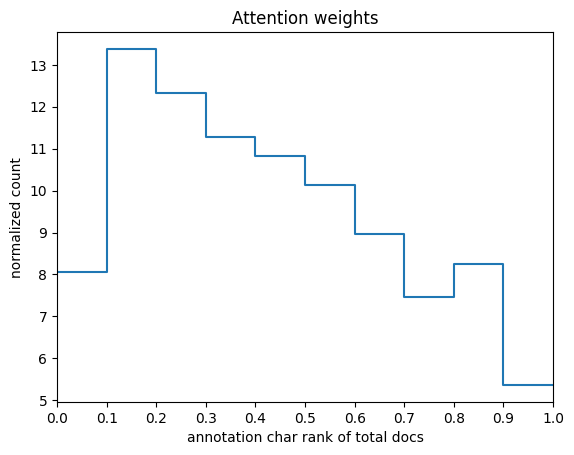

In [9]:
xpoints,ypoints=generate(bins,accumulate_rels)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ypoints)
ax.set_xlim(0,1)#x轴从1到7.1
ax.set_title("Attention weights")
ax.set_xlabel("annotation char rank of total docs")
ax.set_ylabel("normalized count")

ax.set_xticks(np.linspace(0,1,len(bins)))

plt.show()

In [10]:
bm25_imp_p="./bm25_importance/bm25_words_top-1_query_rmstop.json" # 去除停用词后的bm25 score
with open(bm25_imp_p) as fr:
    bm25_imp=json.load(fr)

bm25_dic={}
for qid in bm25_imp:
    bm25items=bm25_imp[qid]
    wdic={}
    for i,v in bm25items:
        if i in wdic:
            print(qid,i)
        wdic[i]=v
    bm25_dic[qid]=wdic

In [11]:
def value_ratio(valuedict):
    ratiodic={}

    valuels=sorted(valuedict.items(),key=lambda x:x[1],reverse=True)
    # print(valuels)
    for index,(wordpos,v) in enumerate(valuels):
        ratiodic[wordpos]=(index+1)/len(valuels)
    return ratiodic

value_ratio({"x":1,"y":2,"zyc":321})

{'zyc': 0.3333333333333333, 'y': 0.6666666666666666, 'x': 1.0}

## word level analysis, we use ratio here

In [12]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

heatcounts=np.zeros((len(bins)-1,len(bins)-1))
heatncounts=np.zeros((len(bins)-1,len(bins)-1))

heattfs=np.zeros((len(bins)-1,len(bins)-1))
heatidfs=np.zeros((len(bins)-1,len(bins)-1))
heattfidfs=np.zeros((len(bins)-1,len(bins)-1))

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)

bm25truncindex={}
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]

        label=labelgen(annotation) #原始query的label,不含有;
        origintext=qdict[qid] #原始query
        transdoc=doc2q[str(qid)] # 对bert,tokenization后还原的query,含CLS、SEP
        attention=attmap[str(qid)] #attenion map: cls视野下从cls到sep-1的位置
        offsets=query_offset[str(qid)] # tokenized offsets;token to char
        qpos=qcorpus[str(qid)] # query word split by jieba
        
        attw=attwordana(label,offsets[1:],attention[1:]) 
        # attention weights不包含CLS tokens;char level attention attw
        offsetsls=wordoffsets(qpos,origintext)

        wordattention={} # word index in wordls and attention area
        wordbm25={} # word index in wordls and attention area
        bm25weightdic=bm25_dic[str(qid)]
        for index,(b,e) in enumerate(offsetsls):
            if b==-1 and e==-1:
                continue
            if b >= len(attw) or e>=len(attw):
                break
            attenw=0
            charcount=0
            tok=qpos[index]
            if tok in bm25weightdic:
                # make sure the word appear both in bm25 and attention area
                wordbm25[index]=bm25weightdic[tok]
                for i in range(b,e):
                    if i >=len(attw):
                        break
                    attenw+=attw[i]
                    charcount+=1
                if charcount!=0:
                    attenw/=charcount # we count average attention
                wordattention[index]=attenw
                tok=qpos[index]
        assert len(wordattention)==len(wordbm25)

        last_wordindex=index # used for bm25 trunc test;
        bm25truncindex[qid]=last_wordindex
        tfcount=Counter(qpos[:last_wordindex])

        # get the word attention rank and change to bins
        rankres=sorted(wordattention.items(),key=lambda x:x[1],reverse=True) #对于所有原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry[0] means the index of wordls;charindex:rank
        
        # 可能这里有点问题?
        attannot_posr={}
        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
            if wordimpflag:
                attannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        attindex=binindex(attannot_posr,bins)

        # get the word importance rank and change to bins
        rankres=sorted(wordbm25.items(),key=lambda x:x[1],reverse=True) #对于所有原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry[0] means the index of wordls;charindex:rank
        
        wordannot_posr={}
        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
                    break
            if wordimpflag:
                wordannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        wordindex=binindex(wordannot_posr,bins)
        if len(attindex)==0:
            print(qid) # dense attention problem
            continue

        qtf_value={}
        qidf_value={}
        qtfidf_value={}

        for wordpos in wordindex:
            # 在图上的横坐标是y,纵坐标是x
            # 横坐标y是dense retrieval model rank，纵坐标x是bm25 rank
            x=wordindex[wordpos]
            y=attindex[wordpos]
            heatcounts[x][y]+=1
            heatncounts[x][y]+=1/len(wordindex)
            tok=qpos[wordpos]

            tf=tfcount[tok]
            qtf_value[wordpos]=tf

            
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]

            qidf_value[wordpos]=idf
            qtfidf_value[wordpos]=idf*tf
        
        qtf_ratio=value_ratio(qtf_value)
        qidf_ratio=value_ratio(qidf_value)
        qtfidf_ratio=value_ratio(qtfidf_value)
    
        for wordpos in qidf_value.keys():
            x=wordindex[wordpos]
            y=attindex[wordpos]
            
            heattfs[x][y]+=qtf_ratio[wordpos]
            heatidfs[x][y]+=qidf_ratio[wordpos]
            heattfidfs[x][y]+=qtfidf_ratio[wordpos]

heatcounts=np.flip(heatcounts,axis=0)
heatncounts=np.flip(heatncounts,axis=0)

heatidfs=np.flip(heatidfs,axis=0)
heattfs=np.flip(heattfs,axis=0)
heattfidfs=np.flip(heattfidfs,axis=0)
            

1355
1978
21
2143
22
3
3805
4738
4794
4852
6072


In [13]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heatidfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
hist_fig = ax.get_figure()
ax.set_title("Average idf ratio")
hist_fig.savefig("./plots/idf_ratio.png",dpi=1000)
plt.clf()
plt.close()

In [14]:
a=np.array([[1,2,3,4],[5,6,7,8]])
np.sum(a,axis=1)

array([10, 26])

In [15]:
print(np.sum(heatidfs,axis=1))
print(np.sum(heatcounts,axis=1))
print(np.sum(heatidfs,axis=1)/np.sum(heatcounts,axis=1))

[115.57089288 109.11881627 114.11504266  81.80802087  61.4765616
  77.40371392  55.1691472   47.66385523  52.98878998  45.18515941]
[132. 145. 173. 159. 150. 166. 134. 123. 126. 124.]
[0.87553707 0.75254356 0.65962452 0.51451585 0.40984374 0.46628743
 0.41171005 0.38751102 0.42054595 0.36439645]


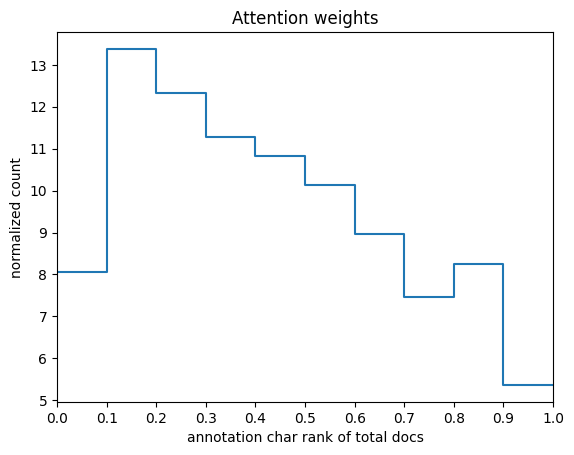

In [16]:
xpoints,ypoints=generate(bins,accumulate_rels)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ypoints)
ax.set_xlim(0,1)#x轴从1到7.1
ax.set_title("Attention weights")
ax.set_xlabel("annotation char rank of total docs")
ax.set_ylabel("normalized count")

ax.set_xticks(np.linspace(0,1,len(bins)))

plt.show()

In [17]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heattfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
ax.set_title("Average tf ratio")
hist_fig = ax.get_figure()
hist_fig.savefig("./plots/tf_ratio.png",dpi=1000)
plt.clf()
plt.close()

In [18]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heattfidfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
hist_fig = ax.get_figure()
ax.set_title("Average tfidf ratio")
hist_fig.savefig("./plots/tfidf_ratio.png",dpi=1000)
plt.clf()
plt.close()

# using the tf\idf\tf*idf average value instead of ratio

In [19]:
bins = [0,0.2,0.4,0.6,0.8,1]

In [20]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

heatcounts=np.zeros((len(bins)-1,len(bins)-1))
heatncounts=np.zeros((len(bins)-1,len(bins)-1))

heattfs=np.zeros((len(bins)-1,len(bins)-1))
heatidfs=np.zeros((len(bins)-1,len(bins)-1))
heattfidfs=np.zeros((len(bins)-1,len(bins)-1))

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)

bm25truncindex={}
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]

        label=labelgen(annotation) #原始query的label,不含有;
        origintext=qdict[qid] #原始query
        transdoc=doc2q[str(qid)] # tokenization后还原,含CLS、SEP
        attention=attmap[str(qid)] #attenion map: cls视野下从cls到sep-1的位置
        offsets=query_offset[str(qid)] # tokenized offsets
        qpos=qcorpus[str(qid)] # query word split by jieba
        
        attw=attwordana(label,offsets[1:],attention[1:]) 
        # attention weights不包含CLS tokens;char level attention attw
        offsetsls=wordoffsets(qpos,origintext)

        wordattention={} # word index in wordls; index:word attention weights
        wordbm25={} # bm25 weights dict;
        bm25weightdic=bm25_dic[str(qid)]
        for index,(b,e) in enumerate(offsetsls):
            if b==-1 and e==-1:
                continue
            if b >= len(attw) or e>=len(attw):
                break
            attenw=0
            charcount=0
            tok=qpos[index]
            if tok in bm25weightdic:
                # make sure the word appear both in bm25 and attention area
                wordbm25[index]=bm25weightdic[tok] 
                # 直接获取BM25重要性;
                for i in range(b,e):
                # 获取word的attention值
                    if i >=len(attw):
                        break
                    attenw+=attw[i]
                    charcount+=1
                if charcount!=0:
                # 计算word的平均attention
                    attenw/=charcount # we count average attention
                wordattention[index]=attenw
                tok=qpos[index]

        last_wordindex=index # used for bm25 trunc test;
        bm25truncindex[qid]=last_wordindex
        tfcount=Counter(qpos[:last_wordindex])

        # get the word attention rank and change to bins
        rankres=sorted(wordattention.items(),key=lambda x:x[1],reverse=True) #对于所有原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry[0] means the index of wordls;charindex:rank
        
        attannot_posr={}
        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
            if wordimpflag:
                attannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part
        
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        attindex=binindex(attannot_posr,bins)

        # get the word importance rank and change to bins
        rankres=sorted(wordbm25.items(),key=lambda x:x[1],reverse=True) #对于所有原始词语的bm25排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry[0] means the index of wordls;rank is the word rank
        
        # annotword=annot_wordcut(annotation) # only include word in positions

        wordannot_posr={}
        # ditinguish the same word in different position
        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
                    break
            if wordimpflag:
                wordannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        # do not ditinguish the same word in different position;onlut refer to the words;
        # wordannot_posr={}
        # for wordidx in rankdic:
        #     # if any label fell into the word offset,we think it is important words;
        #     qword=qpos[wordidx]
        #     if qword in annotword:
        #         wordannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        wordindex=binindex(wordannot_posr,bins)
        if len(attindex)==0:
            print(qid) # dense attention problem
            continue
        for wordpos in attannot_posr:
            # 在图上的横坐标是y,纵坐标是x
            # 横坐标y是dense retrieval model rank，纵坐标x是bm25 rank
            # if wordpos >= last_wordindex:
            #     continue
            # if wordpos not in wordindex:
            #     continue
            x=wordindex[wordpos]
            y=attindex[wordpos]
            heatcounts[x][y]+=1
            heatncounts[x][y]+=1/len(wordindex)
            tok=qpos[wordpos]

            tf=tfcount[tok]
            heattfs[x][y]+=tf
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            heatidfs[x][y]+=idf
            heattfidfs[x][y]+=idf*tf

# heatcounts=np.flip(heatcounts,axis=0) #上下翻转
# heatncounts=np.flip(heatncounts,axis=0)
# print(heatcounts)
# print(heatncounts)

heatidfs=np.flip(heatidfs,axis=0)

heattfs=np.flip(heattfs,axis=0)
heattfidfs=np.flip(heattfidfs,axis=0)
            

1355
1978
21
2143
22
3
3805
4738
4794
4852
6072


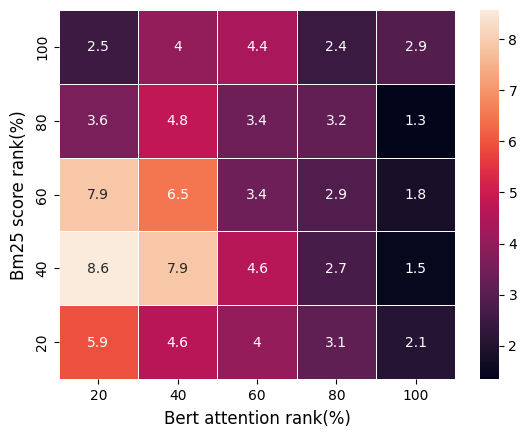

In [21]:
# print(heatncounts)

# labels=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))][1:]
# ylabels=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))][1:][::-1]

labels=[str(int(x)) for x in np.linspace(0,100,len(bins))][1:]
ylabels=[str(int(x)) for x in np.linspace(0,100,len(bins))][1:][::-1]

# ax = sns.heatmap(heatncounts/np.sum(heatcounts), annot=True,xticklabels=labels,yticklabels=ylabels,
#             fmt=".4f",linewidths=.5)

ax = sns.heatmap(100*heatncounts/np.sum(heatncounts), annot=True,xticklabels=labels,yticklabels=ylabels,
        linewidths=.5) #fmt=".2e"

ax.set_ylabel('Bm25 score rank(%)', fontsize = 12,labelpad=5)
ax.set_xlabel('Bert attention rank(%)', fontsize = 12,labelpad=5)
hist_fig = ax.get_figure()
# ax.set_title("ratio")

ax.set_yticklabels(ax.get_yticklabels()) #  rotation=45
ax.set_xticklabels(ax.get_xticklabels()) # rotation=45

hist_fig.savefig("./plots/ncount_ratio.png",dpi=1000)

plt.show()
plt.clf()
plt.close()

In [22]:
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [23]:
queryroot="./annot"

query_p="query.json"
doc2q_p="./atten_new/doc2q_char.json"
attmap_p="./atten_new/atten_map_6_6.pkl"
query_offset_p="./atten_new/query_offset.pkl"

heatcounts=np.zeros((len(bins)-1,len(bins)-1))
heatncounts=np.zeros((len(bins)-1,len(bins)-1))

heattfs=np.zeros((len(bins)-1,len(bins)-1))
heatidfs=np.zeros((len(bins)-1,len(bins)-1))
heattfidfs=np.zeros((len(bins)-1,len(bins)-1))

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)

bm25truncindex={}
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]

        label=labelgen(annotation) #原始query的label,不含有;
        origintext=qdict[qid] #原始query
        transdoc=doc2q[str(qid)] # tokenization后还原,含CLS、SEP
        attention=attmap[str(qid)] #attenion map: cls视野下从cls到sep-1的位置
        offsets=query_offset[str(qid)] # tokenized offsets
        qpos=qcorpus[str(qid)] # query word split by jieba
        
        attw=attwordana(label,offsets[1:],attention[1:]) 
        # attention weights不包含CLS tokens;char level attention attw
        offsetsls=wordoffsets(qpos,origintext)

        wordattention={} # word index in wordls; index:word attention weights
        wordbm25={} # bm25 weights dict;
        bm25weightdic=bm25_dic[str(qid)]
        for index,(b,e) in enumerate(offsetsls):
            if b==-1 and e==-1:
                continue
            if b >= len(attw) or e>=len(attw):
                break
            attenw=0
            charcount=0
            tok=qpos[index]
            if tok in bm25weightdic:
                # make sure the word appear both in bm25 and attention area
                wordbm25[index]=bm25weightdic[tok] 
                # 直接获取BM25重要性;
                for i in range(b,e):
                # 获取word的attention值
                    if i >=len(attw):
                        break
                    attenw+=attw[i]
                    charcount+=1
                if charcount!=0:
                # 计算word的平均attention
                    attenw/=charcount # we count average attention
                wordattention[index]=attenw
                tok=qpos[index]

        last_wordindex=index # used for bm25 trunc test;
        bm25truncindex[qid]=last_wordindex
        tfcount=Counter(qpos[:last_wordindex])

        # get the word attention rank and change to bins
        rankres=sorted(wordattention.items(),key=lambda x:x[1],reverse=True) #对于所有原始词语的排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry[0] means the index of wordls;charindex:rank
        
        attannot_posr={}
        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
            if wordimpflag:
                attannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part
        
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        attindex=binindex(attannot_posr,bins)

        # get the word importance rank and change to bins
        rankres=sorted(wordbm25.items(),key=lambda x:x[1],reverse=True) #对于所有原始词语的bm25排序
        rankdic={}
        for rank,entry in enumerate(rankres):
            rankdic[entry[0]]=rank # entry[0] means the index of wordls;rank is the word rank
        
        # annotword=annot_wordcut(annotation) # only include word in positions

        wordannot_posr={}
        # ditinguish the same word in different position
        for wordidx in rankdic:
            # if any label fell into the word offset,we think it is important words;
            b,e=offsetsls[wordidx]
            wordimpflag=False
            for i in range(b,e):
                if label[i]==1:
                    wordimpflag=True
                    break
            if wordimpflag:
                wordannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        # do not ditinguish the same word in different position;onlut refer to the words;
        # wordannot_posr={}
        # for wordidx in rankdic:
        #     # if any label fell into the word offset,we think it is important words;
        #     qword=qpos[wordidx]
        #     if qword in annotword:
        #         wordannot_posr[wordidx]=(rankdic[wordidx]/len(rankres))

        if len(annot_pos)==0:
            print(qid)
            continue # means the label not in the truc part
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        wordindex=binindex(wordannot_posr,bins)
        if len(attindex)==0:
            print(qid) # dense attention problem
            continue
        for wordpos in attannot_posr:
            # 在图上的横坐标是y,纵坐标是x
            # 横坐标y是dense retrieval model rank，纵坐标x是bm25 rank
            # if wordpos >= last_wordindex:
            #     continue
            # if wordpos not in wordindex:
            #     continue
            x=wordindex[wordpos]
            y=attindex[wordpos]
            heatcounts[x][y]+=1
            heatncounts[x][y]+=1/len(wordindex)
            tok=qpos[wordpos]

            tf=tfcount[tok]
            heattfs[x][y]+=tf
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            heatidfs[x][y]+=idf
            heattfidfs[x][y]+=idf*tf

heatcounts=np.flip(heatcounts,axis=0) #上下翻转
heatncounts=np.flip(heatncounts,axis=0)
# print(heatcounts)
# print(heatncounts)

heatidfs=np.flip(heatidfs,axis=0)

heattfs=np.flip(heattfs,axis=0)
heattfidfs=np.flip(heattfidfs,axis=0)
            

1355
1978
21
2143
22
3
3805
4738
4794
4852
6072


In [24]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heatidfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
hist_fig = ax.get_figure()
ax.set_title("Average idf ratio")
hist_fig.savefig("./plots/idf_ratio.png",dpi=1000)
plt.clf()
plt.close()

[[14. 20. 15. 18. 13. 16. 12. 12. 10.  2.]
 [27. 19. 13. 20. 11. 17. 13. 11. 11.  3.]
 [32. 30. 19. 25. 15. 14. 14.  8.  9.  7.]
 [27. 18. 31. 20. 14. 17. 10. 12.  5.  5.]
 [31. 26. 25. 17. 13.  7. 12.  8.  6.  5.]
 [30. 20. 26. 19. 28. 11.  9.  6. 10.  7.]
 [18. 19. 18. 17. 12. 12. 13.  9. 11.  5.]
 [10. 14. 19. 13. 14. 14. 16. 14.  5.  4.]
 [10.  7. 14. 14. 14. 21. 11.  7. 13. 15.]
 [11.  9.  8. 16. 20. 17. 12.  8. 10. 13.]]
[1.89504212 2.73878072 3.51286392 4.52225733 5.6101998  5.24426767
 6.10794683 6.29848032 6.0486041  6.65308563]
[15.03119966  9.50592508  9.81666214  6.61896392  5.55263977  4.94528901
  3.43666456  2.14263011  2.10795363  1.45153526]
['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


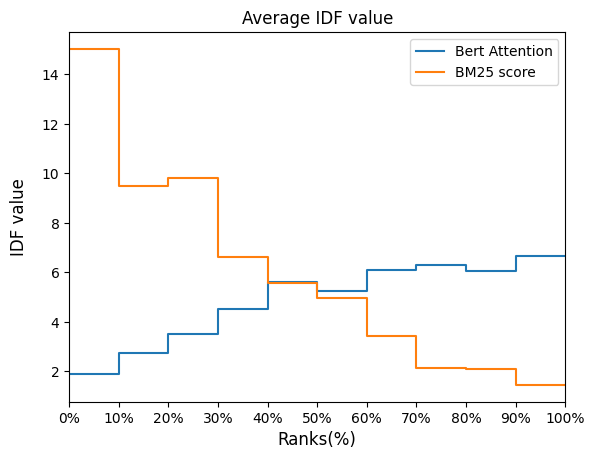

In [25]:
print(heatcounts)
attention=np.sum(heatidfs,axis=1)/np.sum(heatcounts,axis=1)
bm25=np.sum(heatidfs,axis=0)/np.sum(heatcounts,axis=0)[::-1] # 需要逆序

print(attention)
print(bm25)

xpoints,yattention=generate(bins,attention)
xpoints,ybm25=generate(bins,bm25)

#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, yattention,label="Bert Attention")
ax.plot(xpoints, ybm25,label="BM25 score")
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_title("Average IDF value")
ax.set_xlabel("Ranks(%)",fontsize=12)
ax.set_ylabel("IDF value",fontsize=12,labelpad=10)

xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

plt.legend()
plt.show()

In [26]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heatidfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
hist_fig = ax.get_figure()
ax.set_title("Average idf ratio")
hist_fig.savefig("./plots/idf_ratio.png",dpi=1000)
plt.clf()
plt.close()

[[14. 20. 15. 18. 13. 16. 12. 12. 10.  2.]
 [27. 19. 13. 20. 11. 17. 13. 11. 11.  3.]
 [32. 30. 19. 25. 15. 14. 14.  8.  9.  7.]
 [27. 18. 31. 20. 14. 17. 10. 12.  5.  5.]
 [31. 26. 25. 17. 13.  7. 12.  8.  6.  5.]
 [30. 20. 26. 19. 28. 11.  9.  6. 10.  7.]
 [18. 19. 18. 17. 12. 12. 13.  9. 11.  5.]
 [10. 14. 19. 13. 14. 14. 16. 14.  5.  4.]
 [10.  7. 14. 14. 14. 21. 11.  7. 13. 15.]
 [11.  9.  8. 16. 20. 17. 12.  8. 10. 13.]]
[[16. 22. 16. 18. 14. 17. 12. 19. 15.  2.]
 [29. 19. 15. 21. 11. 18. 13. 12. 17.  4.]
 [38. 34. 28. 28. 18. 16. 15.  8. 10.  9.]
 [31. 18. 39. 22. 15. 20. 11. 14.  6.  8.]
 [32. 27. 31. 18. 15.  9. 16.  9. 12.  8.]
 [36. 34. 43. 37. 39. 16. 17.  7. 18. 13.]
 [27. 32. 24. 36. 22. 17. 17. 20. 23. 13.]
 [16. 22. 46. 25. 37. 31. 39. 32. 19.  9.]
 [20. 26. 47. 41. 38. 55. 25. 24. 52. 58.]
 [28. 31. 38. 54. 70. 56. 44. 26. 29. 53.]]
[1.14393939 1.09655172 1.17919075 1.1572327  1.18       1.56626506
 1.7238806  2.24390244 3.06349206 3.45967742]
[1.3        1.45604396 1.

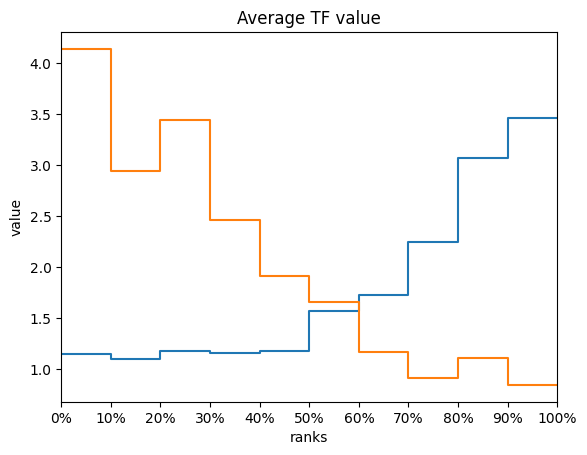

In [27]:
print(heatcounts)
print(heattfs)
# print(np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1))
attention=np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1)
bm25=np.sum(heattfs,axis=0)/np.sum(heatcounts,axis=0)[::-1]
print(attention)
print(np.sum(heattfs,axis=0)/np.sum(heatcounts,axis=0))

xpoints,yatt=generate(bins,attention)
xpoints,ybm25=generate(bins,bm25)

#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)

ax.plot(xpoints, yatt,label="Bert Attention")
ax.plot(xpoints, ybm25,label="BM25 score")
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_title("Average TF value")
ax.set_xlabel("ranks")
ax.set_ylabel("value")

xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
# print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)
plt.show()

In [28]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heattfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
ax.set_title("Average tf ratio")
hist_fig = ax.get_figure()
hist_fig.savefig("./plots/tf_ratio.png",dpi=1000)
plt.clf()
plt.close()

[[14. 20. 15. 18. 13. 16. 12. 12. 10.  2.]
 [27. 19. 13. 20. 11. 17. 13. 11. 11.  3.]
 [32. 30. 19. 25. 15. 14. 14.  8.  9.  7.]
 [27. 18. 31. 20. 14. 17. 10. 12.  5.  5.]
 [31. 26. 25. 17. 13.  7. 12.  8.  6.  5.]
 [30. 20. 26. 19. 28. 11.  9.  6. 10.  7.]
 [18. 19. 18. 17. 12. 12. 13.  9. 11.  5.]
 [10. 14. 19. 13. 14. 14. 16. 14.  5.  4.]
 [10.  7. 14. 14. 14. 21. 11.  7. 13. 15.]
 [11.  9.  8. 16. 20. 17. 12.  8. 10. 13.]]
['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


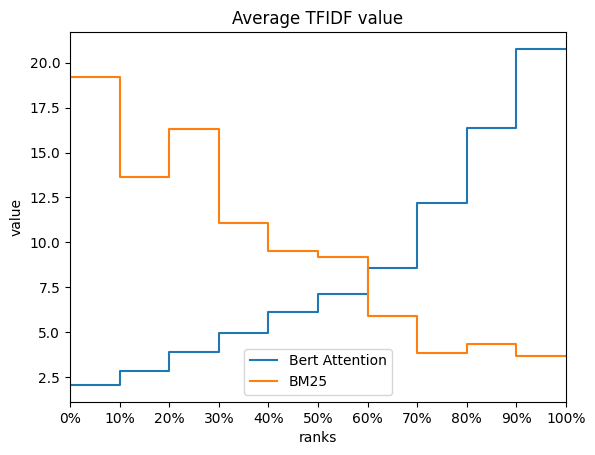

In [29]:
print(heatcounts)
atttfidf=np.sum(heattfidfs,axis=1)/np.sum(heatcounts,axis=1)
bm25tfidf=np.sum(heattfidfs,axis=0)/np.sum(heatcounts,axis=0)[::-1]

xpoints,yatt=generate(bins,atttfidf)
xpoints,ybm25=generate(bins,bm25tfidf)

#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, yatt,label="Bert Attention")
ax.plot(xpoints, ybm25,label="BM25")

ax.set_xlim(0,1)#x轴从1到7.1
ax.set_title("Average TFIDF value")
ax.set_xlabel("ranks")
ax.set_ylabel("value")

ax.set_xticks(np.linspace(0,1,len(bins)))

xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
print(xsticks)
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)
plt.legend()
plt.show()

In [30]:
labels=bins[1:]
ylabels=bins[1:][::-1]
ax = sns.heatmap(heattfidfs/heatcounts, annot=True,xticklabels=labels,yticklabels=ylabels,
                fmt=".2f", linewidths=.5)
ax.set_ylabel('Bm25 rank', fontsize = 14)
ax.set_xlabel('Bert rank', fontsize = 14)
hist_fig = ax.get_figure()
ax.set_title("Average tfidf ratio")
hist_fig.savefig("./plots/tfidf_ratio.png",dpi=1000)
plt.clf()
plt.close()

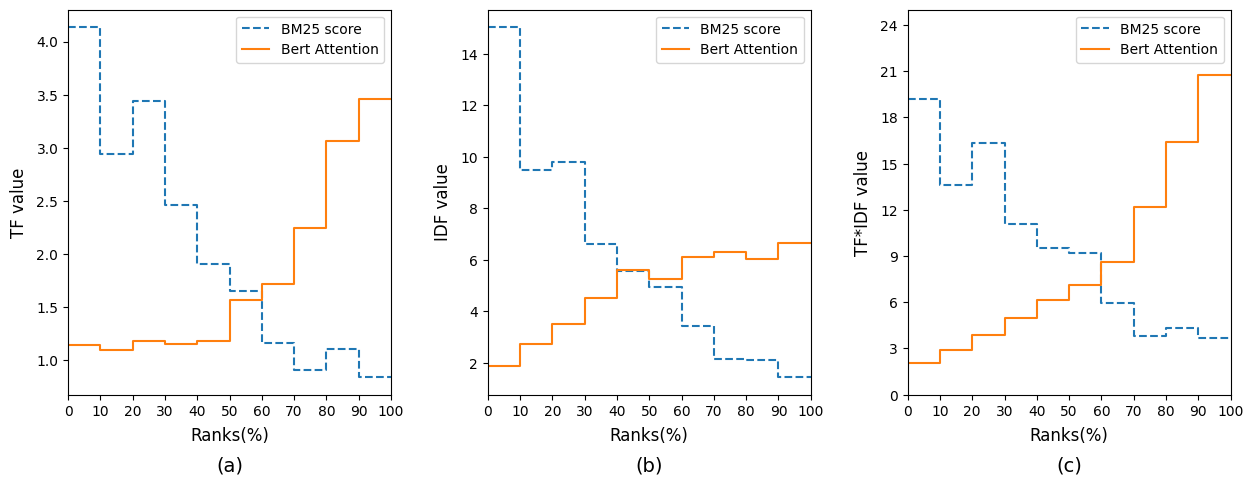

In [31]:

# print(np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1))
# 一、tfvalues
attention=np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1)
bm25=np.sum(heattfs,axis=0)/np.sum(heatcounts,axis=0)[::-1]
xpoints,yatttf=generate(bins,attention)
xpoints,ybm25tf=generate(bins,bm25)

#设置刻度范围
fig=plt.figure(num=1,figsize=(15,5))
ax=plt.subplot(131)
ax.plot(xpoints, ybm25tf,label="BM25 score",linestyle='--')
ax.plot(xpoints, yatttf,label="Bert Attention")

ax.set_xlim(0,1)#x轴从1到7.1
plt.legend()
# ax.set_title("Average TF value")
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=6)
ax.set_ylabel("TF value",fontsize=12,labelpad=6)
ax.set_title("(a)", y=-0.22, fontsize=14)


# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

# 二、idf value
attention=np.sum(heatidfs,axis=1)/np.sum(heatcounts,axis=1)
bm25=np.sum(heatidfs,axis=0)/np.sum(heatcounts,axis=0)[::-1] # 需要逆序

xpoints,yattidf=generate(bins,attention)
xpoints,ybm25idf=generate(bins,bm25)

#设置刻度范围
ax=plt.subplot(132)
ax.plot(xpoints, ybm25idf,label="BM25 score",linestyle='--')
ax.plot(xpoints, yattidf,label="Bert Attention")

ax.set_xlim(0,1)#x轴从1到7.1

# ax.set_title("Average IDF value")
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=6)
ax.set_ylabel("IDF value",fontsize=12,labelpad=6)
ax.set_title("(b)", y=-0.22, fontsize=14)

plt.legend()
# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

# 三、tf*idf subplots
atttfidf=np.sum(heattfidfs,axis=1)/np.sum(heatcounts,axis=1)
bm25tfidf=np.sum(heattfidfs,axis=0)/np.sum(heatcounts,axis=0)[::-1]

xpoints,yatt=generate(bins,atttfidf)
xpoints,ybm25=generate(bins,bm25tfidf)

#设置刻度范围
ax=plt.subplot(133)
ax.plot(xpoints, ybm25,label="BM25 score",linestyle='--')
ax.plot(xpoints, yatt,label="Bert Attention")


ax.set_xlim(0,1)#x轴从1到7.1
# ax.set_title("Average TFIDF value")
ax.set_ylim(0,25)#x轴从1到7.1
ax.yaxis.set_major_locator(ticker.MultipleLocator(3)) # 标签数据间隔;
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=6)
ax.set_ylabel("TF*IDF value",fontsize=12,labelpad=6)
ax.set_title("(c)", y=-0.22, fontsize=14)

# ax.set_xticks(np.linspace(0,1,len(bins)))

# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
# print(xsticks)
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=0.3) # wspace 左右距离;hspace 上下距离

plt.legend()
plt.show()

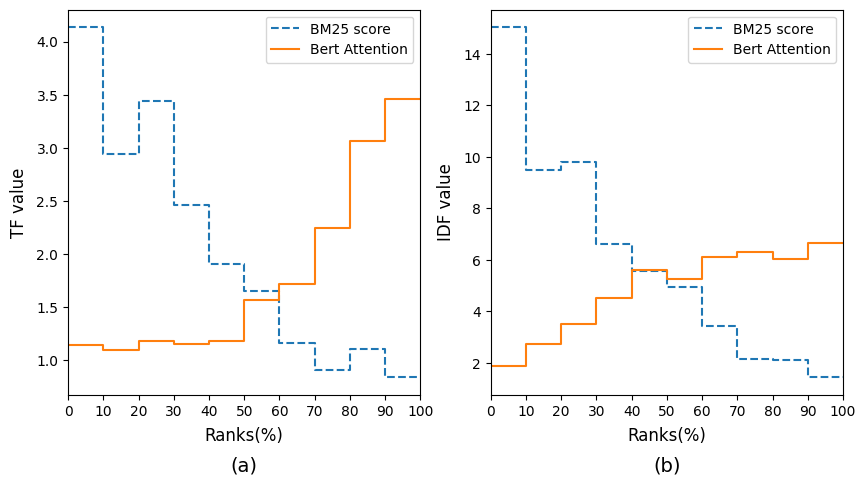

In [32]:

# print(np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1))
# 一、tfvalues
attention=np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1)
bm25=np.sum(heattfs,axis=0)/np.sum(heatcounts,axis=0)[::-1]
xpoints,yatttf=generate(bins,attention)
xpoints,ybm25tf=generate(bins,bm25)

#设置刻度范围
fig=plt.figure(num=1,figsize=(10,5))
ax=plt.subplot(121)
ax.plot(xpoints, ybm25tf,label="BM25 score",linestyle='--')
ax.plot(xpoints, yatttf,label="Bert Attention")

ax.set_xlim(0,1)#x轴从1到7.1
plt.legend()
# ax.set_title("Average TF value")
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=6)
ax.set_ylabel("TF value",fontsize=12,labelpad=6)
ax.set_title("(a)", y=-0.22, fontsize=14)


# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

# 二、idf value
attention=np.sum(heatidfs,axis=1)/np.sum(heatcounts,axis=1)
bm25=np.sum(heatidfs,axis=0)/np.sum(heatcounts,axis=0)[::-1] # 需要逆序

xpoints,yattidf=generate(bins,attention)
xpoints,ybm25idf=generate(bins,bm25)

#设置刻度范围
ax=plt.subplot(122)
ax.plot(xpoints, ybm25idf,label="BM25 score",linestyle='--')
ax.plot(xpoints, yattidf,label="Bert Attention")

ax.set_xlim(0,1)#x轴从1到7.1

# ax.set_title("Average IDF value")
ax.set_xlabel("Ranks(%)",fontsize=12,labelpad=6)
ax.set_ylabel("IDF value",fontsize=12,labelpad=6)
ax.set_title("(b)", y=-0.22, fontsize=14)

plt.legend()
# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)

# 三、tf*idf subplots
atttfidf=np.sum(heattfidfs,axis=1)/np.sum(heatcounts,axis=1)
bm25tfidf=np.sum(heattfidfs,axis=0)/np.sum(heatcounts,axis=0)[::-1]

xpoints,yatt=generate(bins,atttfidf)
xpoints,ybm25=generate(bins,bm25tfidf)

plt.show()